In [62]:
import io
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import text
from keras.utils import pad_sequences
from matplotlib import pyplot as plt

In [33]:
tokenizer = text.Tokenizer()

In [34]:
corpus = [
    # numbers
    "5 2 4 8 6 2 3 6 4",
    "4 8 5 6 9 5 5 6",
    "1 1 5 2 3 3 8",
    "3 6 9 6 8 7 4 6 3",
    "8 9 9 6 1 4 3 4",
    "1 0 2 0 2 1 3 3 3 3 3",
    "9 3 3 0 1 4 7 8",
    "9 9 8 5 6 7 1 2 3 0 1 0",

    # alphabets, expecting that 9 is close to letters
    "a t g q e h 9 u f",
    "e q y u o i p s",
    "q o 9 p l k j o k o k p",
    "h g y i u t a t e q",
    "i k d q r e 9 e a d",
    "o p d g 9 s a f g a",
    "i u y g h k l a s w",
    "o l u y a o g f s",
    "o p i u y g d a s j d l",
    "u k i l o 9 l j s",
    "y g i s h k j l f r f",
    "i o h n 9 9 d 9 f a 9",
]

In [35]:
tokenizer.fit_on_texts(corpus)
word2id = tokenizer.word_index
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}

In [36]:
corpus = [line.split(' ') for line in corpus]

In [37]:
wids = [[word2id[w] for w in sentence] for sentence in corpus]
vocab_size = len(word2id)

In [92]:
embed_size = 128
window_size = 2
context_length = window_size*2

In [39]:
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 31
Vocabulary Sample: [('9', 1), ('3', 2), ('o', 3), ('6', 4), ('a', 5), ('1', 6), ('g', 7), ('i', 8), ('4', 9), ('8', 10)]


In [40]:
def generate_context_word_pairs(corpus, window_size):
    pairs = []
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = context_words
            y = label_word
            pairs.append((x, y))
    return pairs

pairs = generate_context_word_pairs(wids, 2)

In [41]:
for pair in pairs[:5]:
  print(pair[0], pair[1])

[[16, 9]] [15]
[[15, 9, 10]] [16]
[[15, 16, 10, 4]] [9]
[[16, 9, 4, 16]] [10]
[[9, 10, 16, 2]] [4]


In [ ]:
dataset = [(tf.constant(pad_sequences(pair[0], maxlen=context_length)), tf.one_hot(pair[1], vocab_size))for pair in pairs]

for x, y in dataset[:3]:
  print(x, y)

In [68]:
cbow = keras.Sequential([
  keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2),
  keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(embed_size,)),
  keras.layers.Dense(vocab_size, activation='softmax')
])

cbow.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.003))
cbow.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 4, 80)             2480      
                                                                 
 lambda_6 (Lambda)           (None, 80)                0         
                                                                 
 dense_6 (Dense)             (None, 31)                2511      
                                                                 
Total params: 4,991
Trainable params: 4,991
Non-trainable params: 0
_________________________________________________________________


In [69]:
for epoch in range(1, 500):
    loss = 0.
    i = 0
    for x, y in dataset:
        i += 1
        loss += cbow.train_on_batch(x, y)
    if epoch % 10 == 0:
        print('Epoch:', epoch, '\tLoss:', loss)
        print()

Epoch: 10 	Loss: 310.91029274463654

Epoch: 20 	Loss: 230.26588536798954

Epoch: 30 	Loss: 197.12474937736988

Epoch: 40 	Loss: 178.4592739250511

Epoch: 50 	Loss: 165.7616679170169

Epoch: 60 	Loss: 156.34531836304814

Epoch: 70 	Loss: 149.0464919502847

Epoch: 80 	Loss: 143.20443159760907

Epoch: 90 	Loss: 138.41707822633907

Epoch: 100 	Loss: 134.42472404410364

Epoch: 110 	Loss: 131.04886041558348

Epoch: 120 	Loss: 128.16006222263968

Epoch: 130 	Loss: 125.66056113896775

Epoch: 140 	Loss: 123.47479100868259

Epoch: 150 	Loss: 121.5434887904903

Epoch: 160 	Loss: 119.8173643982891

Epoch: 170 	Loss: 118.25730234170396

Epoch: 180 	Loss: 116.8321265204928

Epoch: 190 	Loss: 115.51717988177609

Epoch: 200 	Loss: 114.2943139038747

Epoch: 210 	Loss: 113.15199878574774

Epoch: 220 	Loss: 112.0850526696438

Epoch: 230 	Loss: 111.11381408335592

Epoch: 240 	Loss: 110.19186795887822

Epoch: 250 	Loss: 109.3221234859999

Epoch: 260 	Loss: 108.52196011759122

Epoch: 270 	Loss: 107.77012768

In [66]:
weights = cbow.get_weights()[0]
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index in tokenizer.index_word:
  if index == 0:
    continue  # skip 0, it's padding.
  word = tokenizer.index_word[index]
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

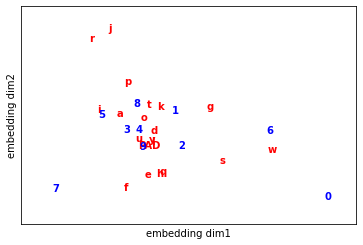

In [108]:
def show_w2v_word_embedding(model, path):
    word_emb = model.get_layer('w2v_embedding').get_weights()[0]
    # word_emb = model.get_weights()[0]
    word_emb = word_emb[1:]
    for i in range(vocab_size -1):
        c = "blue"
        try:
            int(id2word[i])
        except ValueError:
            c = "red"
        plt.text(word_emb[i, 0], word_emb[i, 1], s=id2word[i], color=c, weight="bold")
    plt.xlim(word_emb[:, 0].min() - .5, word_emb[:, 0].max() + .5)
    plt.ylim(word_emb[:, 1].min() - .5, word_emb[:, 1].max() + .5)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("embedding dim1")
    plt.ylabel("embedding dim2")
    plt.savefig(path, dpi=300, format="png")
    plt.show()

show_w2v_word_embedding(word2vec, './cbow.png')